# En este ejercicio vamos a predecir lineas temporales #

(Credits to :  https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a)

Vamos a descargarnos las cotizaciones de dos empresas, Tesla y General Motors, y predecir su capitalización.

Para ello vamos a usar 
 - La librería de facebook fbprophet, para predecir series temporales.
 - Quandle, para coger cotizaciones bursatiles.

<div class="alert alert-danger" role="alert">
  En lo que se refiere a series temporales financieras, **resultados pasados no garantizan ingresos futuros**. <br>
  La información de este ejercicio no debe usarse para intentar hacerse rico.
<div>

 

## Nos descargamos el histórico de cotizaciones de Tesla y General Motors. ##

In [1]:


import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import html5lib

from pathlib import Path
import pickle
import quandl


# Si el objeto ya lo tenemos, nos evitamos el descargarlo, y lo cargamos de disco
my_file = Path("datasets/tesla.pickle")
if my_file.exists():
    with open(r"datasets/tesla.pickle", "rb") as input_file:
        tesla = pickle.load(input_file)
else:
    # Retrieve TSLA data from Quandl
    tesla = quandl.get('WIKI/TSLA')

my_file = Path("datasets/gm.pickle")
if my_file.exists():
    with open(r"datasets/gm.pickle", "rb") as input_file:
        gm = pickle.load(input_file)
else:
    # Retrieve the GM data from Quandl
    gm = quandl.get('WIKI/GM')
            

        


tesla.head(5)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2010-06-29,19.00,25.0000,17.54,23.89,18766300.0,0.0,1.0,19.00,25.0000,17.54,23.89,18766300.0
2010-06-30,25.79,30.4192,23.30,23.83,17187100.0,0.0,1.0,25.79,30.4192,23.30,23.83,17187100.0
2010-07-01,25.00,25.9200,20.27,21.96,8218800.0,0.0,1.0,25.00,25.9200,20.27,21.96,8218800.0
2010-07-02,23.00,23.1000,18.71,19.20,5139800.0,0.0,1.0,23.00,23.1000,18.71,19.20,5139800.0
2010-07-06,20.00,20.0000,15.83,16.11,6866900.0,0.0,1.0,20.00,20.0000,15.83,16.11,6866900.0


## Gráfica de la evolución de la cotización, para ambas empresas. ##

In [2]:
import matplotlib.pyplot as plt

# The adjusted close accounts for stock splits, so that is what we should graph
plt.plot(gm.index, gm['Adj. Close'])
plt.title('GM Stock Price')
plt.ylabel('Price ($)');
plt.show()
plt.plot(tesla.index, tesla['Adj. Close'], 'r')
plt.title('Tesla Stock Price')
plt.ylabel('Price ($)');
plt.show();

## Calculamos, el valor de capitalización de ambas empresa (valor de mercado) ##

Valor de capitalización es el precio de la acción, por el número de acciones.
Market cap= share price * number of shares).



In [3]:
# Yearly average number of shares outstanding for Tesla and GM
tesla_shares = {2018: 168e6, 2017: 162e6, 2016: 144e6, 2015: 128e6, 2014: 125e6, 2013: 119e6, 2012: 107e6, 2011: 100e6, 2010: 51e6}
gm_shares = {2018: 1.42e9, 2017: 1.50e9, 2016: 1.54e9, 2015: 1.59e9, 2014: 1.61e9, 2013: 1.39e9, 2012: 1.57e9, 2011: 1.54e9, 2010:1.50e9}
# Create a year column 
tesla['Year'] = tesla.index.year
# Take Dates from index and move to Date column 
tesla.reset_index(level=0, inplace = True)
tesla['cap'] = 0
# Calculate market cap for all years
for i, year in enumerate(tesla['Year']):
    # Retrieve the shares for the year
    shares = tesla_shares.get(year)
    # Update the cap column to shares times the price
    tesla.ix[i, 'cap'] = shares * tesla.ix[i, 'Adj. Close']
    

In [4]:
# Create a year column 
gm['Year'] = gm.index.year
# Take Dates from index and move to Date column 
gm.reset_index(level=0, inplace = True)
gm['cap'] = 0
# Calculate market cap for all years
for i, year in enumerate(gm['Year']):
    # Retrieve the shares for the year
    shares = gm_shares.get(year)
    # Update the cap column to shares times the price
    gm.ix[i, 'cap'] = shares * gm.ix[i, 'Adj. Close']
    


In [5]:
# Merge the two datasets and rename the columns
cars = gm.merge(tesla, how='inner', on='Date')

cars.rename(columns={'cap_x': 'gm_cap', 'cap_y': 'tesla_cap'}, inplace=True)
# Select only the relevant columns
cars = cars.ix[:, ['Date', 'gm_cap', 'tesla_cap']]
# Divide to get market cap in billions of dollars
cars['gm_cap'] = cars['gm_cap'] / 1e9
cars['tesla_cap'] = cars['tesla_cap'] / 1e9
cars.head()

,Date,gm_cap,tesla_cap
0,2010-11-18,43.941453,1.52439
1,2010-11-19,44.031417,1.58049
2,2010-11-22,43.800079,1.70340
3,2010-11-23,42.733352,1.76307
4,2010-11-24,43.028951,1.80897


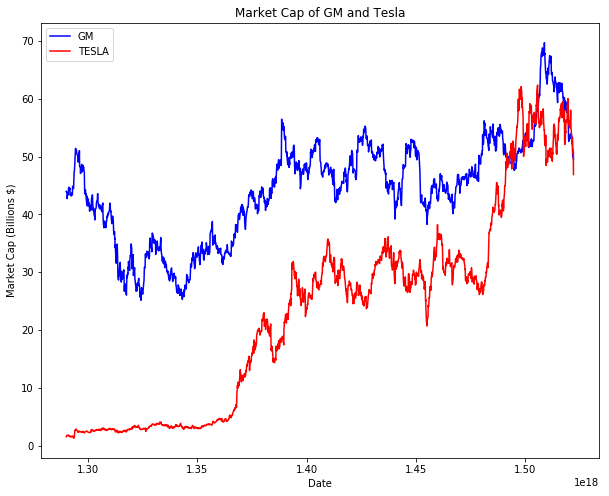

In [6]:
plt.figure(figsize=(10, 8))
plt.plot(cars['Date'], cars['gm_cap'], 'blue', label = 'GM')
plt.plot(cars['Date'], cars['tesla_cap'], 'red', label = 'TESLA')
plt.xlabel('Date')
plt.ylabel('Market Cap (Billions $)') ; plt.title('Market Cap of GM and Tesla')
plt.legend();

In [7]:
import numpy as np
# Find the first and last time Tesla was valued higher than GM
first_date = cars.ix[np.min(list(np.where(cars['tesla_cap'] > cars['gm_cap'])[0])), 'Date']
last_date = cars.ix[np.max(list(np.where(cars['tesla_cap'] > cars['gm_cap'])[0])), 'Date']
print("Tesla was valued higher than GM from {} to {}.".format(first_date.date(), last_date.date()))

Tesla was valued higher than GM from 2017-04-10 to 2018-03-23.


## Preprocesamos la información para que adopta el formato que espera fbprophet ##

 - Columna "ds", con la fecha.
 - Columna "y", por cada valor a predecir : Capitalización de cada empresa.


In [8]:
# Prophet requires columns ds (Date) and y (value)
gm = gm.rename(columns={'Date': 'ds', 'cap': 'y'})
# Put market cap in billions
gm['y'] = gm['y'] / 1e9
# Make the prophet model and fit on the data
gm

,ds,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,Year,y
0,2010-11-18,35.00,35.9900,33.8900,34.19,457044300.0,0.0,1.0,29.988317,30.836558,29.037259,29.294302,457044300.0,2010,43.941453
1,2010-11-19,34.15,34.5000,33.1100,34.26,107842000.0,0.0,1.0,29.260029,29.559912,28.368948,29.354278,107842000.0,2010,44.031417
2,2010-11-22,34.20,34.4800,33.8100,34.08,36650600.0,0.0,1.0,29.302870,29.542776,28.968714,29.200053,36650600.0,2010,43.800079
3,2010-11-23,33.95,33.9900,33.1900,33.25,31170200.0,0.0,1.0,29.088668,29.122940,28.437493,28.488901,31170200.0,2010,42.733352
4,2010-11-24,33.73,33.8000,33.2200,33.48,26138000.0,0.0,1.0,28.900170,28.960146,28.463197,28.685967,26138000.0,2010,43.028951
5,2010-11-26,33.41,33.8100,33.2100,33.80,12301200.0,0.0,1.0,28.625991,28.968714,28.454629,28.960146,12301200.0,2010,43.440219
6,2010-11-29,33.80,33.8100,33.0700,33.80,27776900.0,0.0,1.0,28.960146,28.968714,28.334676,28.960146,27776900.0,2010,43.440219
7,2010-11-30,33.53,34.2500,33.3600,34.20,57476900.0,0.0,1.0,28.728808,29.345710,28.583150,29.302870,57476900.0,2010,43.954305
8,2010-12-01,34.65,34.9500,34.4200,34.78,34633200.0,0.0,1.0,29.688434,29.945477,29.491368,29.799819,34633200.0,2010,44.699729
9,2010-12-02,34.92,34.9800,34.5100,34.68,23196100.0,0.0,1.0,29.919772,29.971181,29.568481,29.714138,23196100.0,2010,44.571207


## Generamos el modelo para hacer la predicción ## 

<div class="alert alert-info" role="alert">
 Fbprophet nos da un modelo, que una vez entrenado nos predecirá los valores futuros de la serie temporal, incluyendo tendencias, valores  máximos/minimos, y otrtos valores
<div>

 

In [9]:
import fbprophet

gm_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
gm_prophet.fit(gm)

# Make a future dataframe for 2 years
gm_forecast = gm_prophet.make_future_dataframe(periods=365 * 2, freq='D')
# Make predictions
gm_forecast = gm_prophet.predict(gm_forecast)
gm_forecast


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2010-11-18,42.598037,42.598037,42.598037,41.709912,48.419069,2.571893,2.571893,2.571893,2.571893,2.571893,2.571893,0.190352,0.190352,0.190352,2.381541,2.381541,2.381541,45.169930
1,2010-11-19,42.627365,42.627365,42.627365,41.851842,48.357291,2.569809,2.569809,2.569809,2.569809,2.569809,2.569809,0.136573,0.136573,0.136573,2.433236,2.433236,2.433236,45.197174
2,2010-11-22,42.715347,42.715347,42.715347,42.418404,48.729371,2.768962,2.768962,2.768962,2.768962,2.768962,2.768962,0.168370,0.168370,0.168370,2.600592,2.600592,2.600592,45.484309
3,2010-11-23,42.744674,42.744674,42.744674,42.284583,49.011583,2.767823,2.767823,2.767823,2.767823,2.767823,2.767823,0.112445,0.112445,0.112445,2.655378,2.655378,2.655378,45.512497
4,2010-11-24,42.774002,42.774002,42.774002,42.476715,48.886089,2.897347,2.897347,2.897347,2.897347,2.897347,2.897347,0.190303,0.190303,0.190303,2.707044,2.707044,2.707044,45.671348
5,2010-11-26,42.832656,42.832656,42.832656,42.506120,48.891859,2.931607,2.931607,2.931607,2.931607,2.931607,2.931607,0.136573,0.136573,0.136573,2.795033,2.795033,2.795033,45.764263
6,2010-11-29,42.920639,42.920639,42.920639,42.773344,49.398406,3.038026,3.038026,3.038026,3.038026,3.038026,3.038026,0.168370,0.168370,0.168370,2.869656,2.869656,2.869656,45.958664
7,2010-11-30,42.949966,42.949966,42.949966,42.826371,49.272289,2.987961,2.987961,2.987961,2.987961,2.987961,2.987961,0.112445,0.112445,0.112445,2.875516,2.875516,2.875516,45.937927
8,2010-12-01,42.979293,42.979293,42.979293,42.684248,49.272037,3.061333,3.061333,3.061333,3.061333,3.061333,3.061333,0.190303,0.190303,0.190303,2.871030,2.871030,2.871030,46.040627
9,2010-12-02,43.008621,43.008621,43.008621,42.946993,49.292842,3.046467,3.046467,3.046467,3.046467,3.046467,3.046467,0.190352,0.190352,0.190352,2.856115,2.856115,2.856115,46.055088


In [10]:
# Se puede hacer mas limpio, solo con las dos columnas
df = pd.DataFrame()
df["ds"] = gm["ds"]
df["y"] = gm["y"]
df
import fbprophet


df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
df_prophet.fit(df)

# Make a future dataframe for 2 years
df_forecast = df_prophet.make_future_dataframe(periods=365 * 2, freq='D')
# Make predictions
df_forecast = df_prophet.predict(df_forecast)
df_forecast


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2010-11-18,42.598037,42.598037,42.598037,41.936148,48.528768,2.571893,2.571893,2.571893,2.571893,2.571893,2.571893,0.190352,0.190352,0.190352,2.381541,2.381541,2.381541,45.169930
1,2010-11-19,42.627365,42.627365,42.627365,41.899038,48.234260,2.569809,2.569809,2.569809,2.569809,2.569809,2.569809,0.136573,0.136573,0.136573,2.433236,2.433236,2.433236,45.197174
2,2010-11-22,42.715347,42.715347,42.715347,42.210635,48.691567,2.768962,2.768962,2.768962,2.768962,2.768962,2.768962,0.168370,0.168370,0.168370,2.600592,2.600592,2.600592,45.484309
3,2010-11-23,42.744674,42.744674,42.744674,42.338464,48.891434,2.767823,2.767823,2.767823,2.767823,2.767823,2.767823,0.112445,0.112445,0.112445,2.655378,2.655378,2.655378,45.512497
4,2010-11-24,42.774002,42.774002,42.774002,42.284427,48.839492,2.897347,2.897347,2.897347,2.897347,2.897347,2.897347,0.190303,0.190303,0.190303,2.707044,2.707044,2.707044,45.671348
5,2010-11-26,42.832656,42.832656,42.832656,42.326319,48.990027,2.931607,2.931607,2.931607,2.931607,2.931607,2.931607,0.136573,0.136573,0.136573,2.795033,2.795033,2.795033,45.764263
6,2010-11-29,42.920639,42.920639,42.920639,42.904618,48.995766,3.038026,3.038026,3.038026,3.038026,3.038026,3.038026,0.168370,0.168370,0.168370,2.869656,2.869656,2.869656,45.958664
7,2010-11-30,42.949966,42.949966,42.949966,42.654586,49.279224,2.987961,2.987961,2.987961,2.987961,2.987961,2.987961,0.112445,0.112445,0.112445,2.875516,2.875516,2.875516,45.937927
8,2010-12-01,42.979293,42.979293,42.979293,42.565358,49.484298,3.061333,3.061333,3.061333,3.061333,3.061333,3.061333,0.190303,0.190303,0.190303,2.871030,2.871030,2.871030,46.040627
9,2010-12-02,43.008621,43.008621,43.008621,42.920849,49.369097,3.046467,3.046467,3.046467,3.046467,3.046467,3.046467,0.190352,0.190352,0.190352,2.856115,2.856115,2.856115,46.055088


## Visualizamos los resultados de la predicción ##

El pronóstico será menos preciso, conforme aumenta el tiempo.


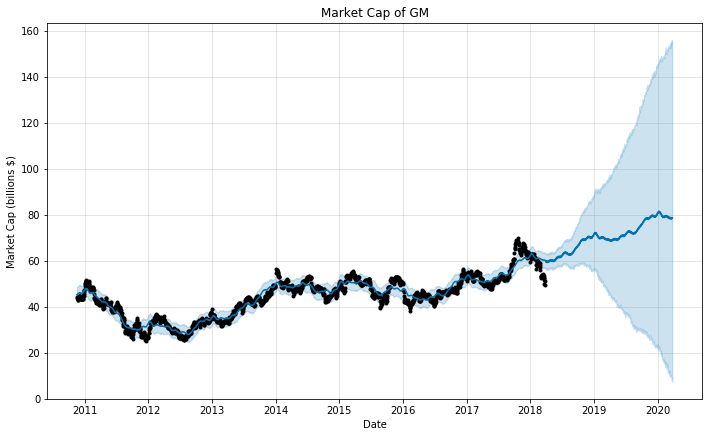

In [11]:
gm_prophet.plot(gm_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of GM')

In [12]:
# Same, with tesla
import fbprophet
# Prophet requires columns ds (Date) and y (value)
tesla = tesla.rename(columns={'Date': 'ds', 'cap': 'y'})
# Put market cap in billions
tesla['y'] = tesla['y'] / 1e9
# Make the prophet model and fit on the data
tesla_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
tesla_prophet.fit(tesla)
# Make a future dataframe for 2 years
tesla_forecast = tesla_prophet.make_future_dataframe(periods=365 * 2, freq='D')
# Make predictions
tesla_forecast = tesla_prophet.predict(tesla_forecast)
tesla_forecast

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2010-06-29,-2.254263,-2.254263,-2.254263,-2.009256,4.169881,3.407989,3.407989,3.407989,3.407989,3.407989,3.407989,-0.695361,-0.695361,-0.695361,4.103351,4.103351,4.103351,1.153726
1,2010-06-30,-2.206463,-2.206463,-2.206463,-2.201641,4.247997,3.338593,3.338593,3.338593,3.338593,3.338593,3.338593,-0.665224,-0.665224,-0.665224,4.003817,4.003817,4.003817,1.132130
2,2010-07-01,-2.158662,-2.158662,-2.158662,-2.204655,4.082106,3.171107,3.171107,3.171107,3.171107,3.171107,3.171107,-0.727711,-0.727711,-0.727711,3.898818,3.898818,3.898818,1.012445
3,2010-07-02,-2.110862,-2.110862,-2.110862,-1.937088,4.230367,3.039452,3.039452,3.039452,3.039452,3.039452,3.039452,-0.750346,-0.750346,-0.750346,3.789798,3.789798,3.789798,0.928590
4,2010-07-06,-1.919661,-1.919661,-1.919661,-2.290603,3.793401,2.648269,2.648269,2.648269,2.648269,2.648269,2.648269,-0.695361,-0.695361,-0.695361,3.343630,3.343630,3.343630,0.728608
5,2010-07-07,-1.871860,-1.871860,-1.871860,-2.678115,3.994230,2.571780,2.571780,2.571780,2.571780,2.571780,2.571780,-0.665224,-0.665224,-0.665224,3.237004,3.237004,3.237004,0.699920
6,2010-07-08,-1.824060,-1.824060,-1.824060,-2.566094,3.648094,2.407407,2.407407,2.407407,2.407407,2.407407,2.407407,-0.727711,-0.727711,-0.727711,3.135119,3.135119,3.135119,0.583348
7,2010-07-09,-1.776260,-1.776260,-1.776260,-2.372993,3.723385,2.288836,2.288836,2.288836,2.288836,2.288836,2.288836,-0.750346,-0.750346,-0.750346,3.039182,3.039182,3.039182,0.512576
8,2010-07-12,-1.632858,-1.632858,-1.632858,-2.501804,3.798616,2.113341,2.113341,2.113341,2.113341,2.113341,2.113341,-0.683595,-0.683595,-0.683595,2.796936,2.796936,2.796936,0.480482
9,2010-07-13,-1.585058,-1.585058,-1.585058,-2.781993,3.488924,2.038446,2.038446,2.038446,2.038446,2.038446,2.038446,-0.695361,-0.695361,-0.695361,2.733808,2.733808,2.733808,0.453388


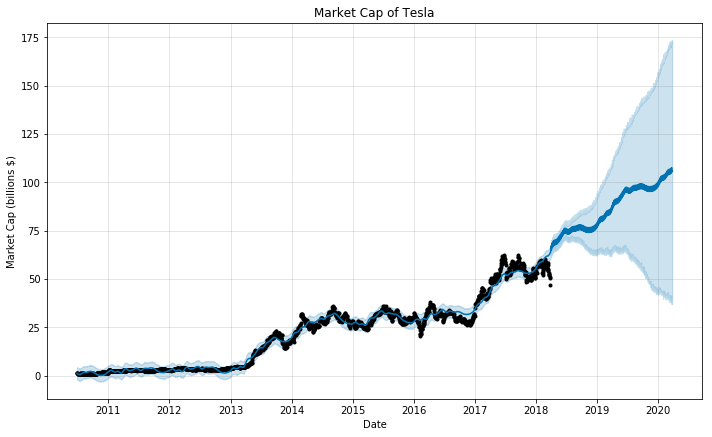

In [13]:
tesla_prophet.plot(tesla_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of Tesla')

## Tambien se pueden detectar los cambios de tendencia alcista/bajista##

In [14]:
gm_prophet.changepoints[:10]


59    2011-02-14
118   2011-05-10
177   2011-08-03
237   2011-10-27
296   2012-01-24
355   2012-04-18
414   2012-07-12
473   2012-10-04
532   2013-01-02
592   2013-04-01
Name: ds, dtype: datetime64[ns]

In [15]:
gm_names = ['gm_%s' % column for column in gm_forecast.columns]
tesla_names = ['tesla_%s' % column for column in tesla_forecast.columns]
# Dataframes to merge
merge_gm_forecast = gm_forecast.copy()
merge_tesla_forecast = tesla_forecast.copy()
# Rename the columns
merge_gm_forecast.columns = gm_names
merge_tesla_forecast.columns = tesla_names
# Merge the two datasets
forecast = pd.merge(merge_gm_forecast, merge_tesla_forecast, how = 'inner', left_on = 'gm_ds', right_on = 'tesla_ds')
# Rename date column
forecast = forecast.rename(columns={'gm_ds': 'Date'}).drop('tesla_ds', axis=1)

In [16]:
forecast

,Date,gm_trend,gm_trend_lower,gm_trend_upper,gm_yhat_lower,gm_yhat_upper,gm_seasonal,gm_seasonal_lower,gm_seasonal_upper,gm_seasonalities,...,tesla_seasonalities,tesla_seasonalities_lower,tesla_seasonalities_upper,tesla_weekly,tesla_weekly_lower,tesla_weekly_upper,tesla_yearly,tesla_yearly_lower,tesla_yearly_upper,tesla_yhat
0,2010-11-18,42.598037,42.598037,42.598037,41.709912,48.419069,2.571893,2.571893,2.571893,2.571893,...,-4.453296,-4.453296,-4.453296,-0.727711,-0.727711,-0.727711,-3.725585,-3.725585,-3.725585,0.080090
1,2010-11-19,42.627365,42.627365,42.627365,41.851842,48.357291,2.569809,2.569809,2.569809,2.569809,...,-4.525259,-4.525259,-4.525259,-0.750346,-0.750346,-0.750346,-3.774913,-3.774913,-3.774913,0.055927
2,2010-11-22,42.715347,42.715347,42.715347,42.418404,48.729371,2.768962,2.768962,2.768962,2.768962,...,-4.597050,-4.597050,-4.597050,-0.683595,-0.683595,-0.683595,-3.913455,-3.913455,-3.913455,0.127537
3,2010-11-23,42.744674,42.744674,42.744674,42.284583,49.011583,2.767823,2.767823,2.767823,2.767823,...,-4.651577,-4.651577,-4.651577,-0.695361,-0.695361,-0.695361,-3.956216,-3.956216,-3.956216,0.120810
4,2010-11-24,42.774002,42.774002,42.774002,42.476715,48.886089,2.897347,2.897347,2.897347,2.897347,...,-4.662364,-4.662364,-4.662364,-0.665224,-0.665224,-0.665224,-3.997140,-3.997140,-3.997140,0.157824
5,2010-11-26,42.832656,42.832656,42.832656,42.506120,48.891859,2.931607,2.931607,2.931607,2.931607,...,-4.823564,-4.823564,-4.823564,-0.750346,-0.750346,-0.750346,-4.073218,-4.073218,-4.073218,0.092224
6,2010-11-29,42.920639,42.920639,42.920639,42.773344,49.398406,3.038026,3.038026,3.038026,3.038026,...,-4.855873,-4.855873,-4.855873,-0.683595,-0.683595,-0.683595,-4.172278,-4.172278,-4.172278,0.203317
7,2010-11-30,42.949966,42.949966,42.949966,42.826371,49.272289,2.987961,2.987961,2.987961,2.987961,...,-4.896567,-4.896567,-4.896567,-0.695361,-0.695361,-0.695361,-4.201205,-4.201205,-4.201205,0.210423
8,2010-12-01,42.979293,42.979293,42.979293,42.684248,49.272037,3.061333,3.061333,3.061333,3.061333,...,-4.893317,-4.893317,-4.893317,-0.665224,-0.665224,-0.665224,-4.228092,-4.228092,-4.228092,0.261474
9,2010-12-02,43.008621,43.008621,43.008621,42.946993,49.292842,3.046467,3.046467,3.046467,3.046467,...,-4.980668,-4.980668,-4.980668,-0.727711,-0.727711,-0.727711,-4.252957,-4.252957,-4.252957,0.221923


## Predecimos cuando ambos valores de capitalización bursatil se cruzarán##

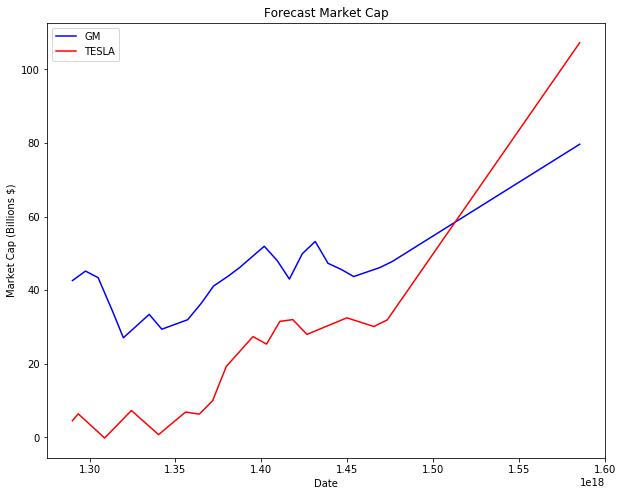

In [17]:
plt.figure(figsize=(10, 8))
plt.plot(forecast['Date'], forecast['gm_trend'], 'blue', label = 'GM')
plt.plot(forecast['Date'], forecast['tesla_trend'], 'red', label = 'TESLA')
plt.xlabel('Date'); plt.ylabel('Market Cap (Billions $)'); plt.title('Forecast Market Cap')
plt.legend();